# Homework 5

## The Heat Equation and the Wave Equation 

### This is the solution of:
* Student1
* Student2
* Student3



The same general rules as for Homework 1 applies.

$\newcommand{\dx}{\,\mathrm{d}x}$ 
$\newcommand{\dy}{\,\mathrm{d}y}$
$\newcommand{\dS}{\,\mathrm{d}S}$

In [43]:
# Make plotted figures interactive
%matplotlib inline

In [44]:
# Download the updated plottools.py file from lab_05 and import it!
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import factorized 
import plottools as pt
import numpy as np
from scipy.sparse import identity

## Problem 1 (The heat equation)

In the following, you are asked to implement the $\theta$ scheme 
combined with the finite element method
as space discretization to solve the heat equation

\begin{alignat*}{3}
\partial_t u  - \Delta u  &= f  \quad && \text{in } \Omega \times (0,T]
\\
u &= g_D \quad && \text{on } \partial \Omega \times (0, T]
\\
u(x,y,0) &=  u_0(x,y) \quad && \text{in } \Omega
\end{alignat*}

with initial value $u_0$, bounday value $g_D$ and final time $T$.

Given a constant step size $\Delta t$ in time, recall that the $\theta$-scheme resulted in a full discretization of the heat equation of the general form
\begin{align*}
(M +  \Delta t\theta A) U^k = (M -  \Delta t \overline{\theta} h A) U^{k-1}
+ \widetilde{F}^k 
\end{align*}
plus boundary conditions. We define $\overline{\theta} = 1 - \theta$.

**a**) Implement a full discretization for the 2d heat equation with $\Omega = (0, 2\pi)^2$ by combining the $\theta$ scheme with the finite element method in space. The data $f$, $g_D$, $u_0$, $T$ are defined later in c) and d). 



To encourage code reuse, wrap your assembler functions from Lab 04
* assemble_mass_matrix
* assemble_stiffness_matrix
* assemble_load_vector 

into a separate assembler module named $\texttt{assemble.py}$ (Don't forget to include helper like $\texttt{compute_hat_grad}$). In principle, the module should like this:

In [45]:
# assemble.py module
import numpy as np
import scipy.sparse as sp

def compute_hat_gradients(tri):
    # Compute area
    ...

    return ...

def assemble_stiffness_matrix(P, T):
    # Create matrix
    ...
    
    return A

def assemble_mass_matrix(P, T):
    ...

    return M

# And so on


Then you can simply use the functions from your new cool module by importing everything
into this notebook:

In [46]:
from assembly import *

Next, we split our previous $\texttt{apply_bcs}$ functions into two parts:
* one which manipulates the rows related to the Dirichlet nodes in a given matrix
(as described in Lab 04) and which will be needed only once.
* one which incorporates the Dirichlet data into given rhs vector b (needed in every time step)

In [47]:
def apply_bcs_to_A(A, dirichlet_nodes):
    # Incorporate boundary conditions in matrix A
    # Set all rows corresponding to Dirichlet nodes to 0
    A[dirichlet_nodes, :] = 0 
    
    # Set diagonal to one
    A[dirichlet_nodes, dirichlet_nodes] = 1

def apply_bcs_to_b(b, g_D_values, dirichlet_nodes):
    # Incorporate boundary condition in vector b
    b[dirichlet_nodes] = g_D_values

Of course, it would be nice to encapsulate these functions into the $\text{assemble.py}$ module as well, so move them there and make sure that you rerun the cell with the 
```Python
from assemble import *
```
statement to reimport your new functions.

In [48]:
from assembly import *
import meshtools as mt
import plottools as pt

Finally, do the same with our 
```extract_nodes(P, inside_domain)``` from Lab 04.

Now you are well equipped to implement your own solver. Start again by defining functions for the given data.

In [49]:
# Exact solution (to be used for testing purpose and EOC later)
def u_ex(x, y, t):
    lamb = -2
    return np.sin(x)*np.sin(y)*np.exp(-2*t)

# Right hand side
def f(x, y, t):
    return 0*np.ones_like(x)

# Initial condition
def u_0(x, y):
    return np.sin(x)*np.sin(y)

# Boundary condition
def g_D(x, y, t):
    return 0*np.ones_like(x)

# Start/end time
t0, T = 0, 1

Next, we define the dimensions of the domain and the Dirichlet boundary.

In [50]:
def on_dirichlet_boundary(x):
    eps = 1e-12
    L = 2*np.pi
    return  (x[0] < eps or x[0] > L - eps or
             x[1] < eps or x[1] > L - eps)

As usual, you need a mesh. (Don't forget to import the meshtools and plottools.)

In [51]:
# Define number of subdivision in each spatial direction
N = 10

# Mesh size
h = 2*np.pi/N

# Mesh and coordinates
points, triangles = mt.rectangle_mesh((0,0), (2*np.pi,2*np.pi), N, N)
X = points[:, 0]
Y = points[:, 1]

In [52]:
# Define stepsize in time, number of time steps, theta, thetabar.
alpha = 1/8 #dt < (h^2)/4 for 2D heat equation, so 1/8 is a valid choice
m = 2
dt = alpha*h**m # choose alpha and m appropriately
N_time = int(np.ceil(T / dt))
dt = T / N_time #redefine dt so that it matches the number of time steps.
# one more thing here -  what could this be?
theta = 1
theta_bar = 1-theta

Now you can assemble the required mass and stiffness matrices and compute
the matrices which are involved in the left and right hand side of a time step computation.
As before,  Dirichlet conditions must be accounted for in the lhs matrix.

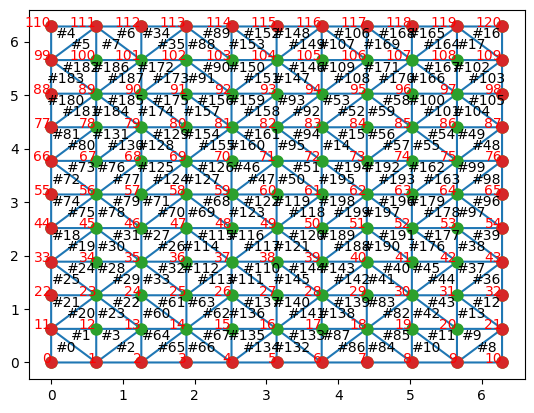

In [53]:
M = assemble_mass_matrix(points, triangles)

a = lambda x: 1
# Compute stiffness matrix
A = assemble_stiffness_matrix(points, triangles, a)

# Compute total matrix for lhs 
A_tot = M + dt*theta*A

# Compute total matrix for rhs
B_tot = M-dt*theta_bar*A 

# Extract Dirichlet nodes 
dirichlet_nodes  = extract_nodes(points, on_dirichlet_boundary)

# Plot them for visual check whether you extracted the right ones.
if N < 11:
    # Plot mesh including dirichlet nodes
    pt.plot_mesh_2d(points, triangles, dirichlet_nodes)

# Adjust rows associated with Dirchlet bc
A_tot = apply_bcs_to_A(A_tot, dirichlet_nodes) 
B_tot = apply_bcs_to_A(B_tot, dirichlet_nodes)

# Convert final matrix to csc format and precompute LU composition
A_tot = A_tot.tocsc()

solve = factorized(A_tot)

Before you can start with the time step looping, an approximation of $u_0$ is needed.

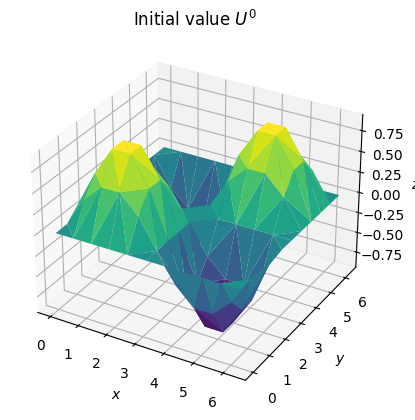

In [54]:
# Current time
t = t0

# (Indirect) interpolation (works only this way since a row wise
# numbering of the nodes is used when the mesh is created!
# Alternative would be to compute the L2 projection
U = u_0(X, Y)
pt.plot2D(X, Y, U, triangles=triangles, title="Initial value $U^0$")
U = U.ravel()

Finally, into the time step looping!

In [55]:
# Start time stepping 
for i in range(N_time):

    # New time and index of time step
    t += dt

    # Compute right hand side action on U
    rhs = B_tot.dot(U)

    # Define \tilde F  
    load = assemble_load_vector_in_time(points, triangles, f, t)
    load_old = assemble_load_vector_in_time(points, triangles, f, t-dt)
    f_tilde = dt*(theta_bar*load_old + theta*load)
    # and assemble the load vector using f_tilde and add it to the rhs
    rhs += f_tilde

    # Extract coordinates associated with Dirichlet nodes as before in Lab 04
    X_dc = X[dirichlet_nodes]
    Y_dc = Y[dirichlet_nodes]

    # Evaluate g at boundary nodes and time t
    g_D_values = g_D(X_dc, Y_dc, t)

    # Apply Dirichlet boundary condition to rhs
    apply_bcs_to_b(rhs, g_D_values, dirichlet_nodes)

    #Solve system
    U = solve( rhs )
print(t) # if t differs from T more than machine precision, then there is bug!

1.0000000000000004


Great, your are done! Time to plot things:

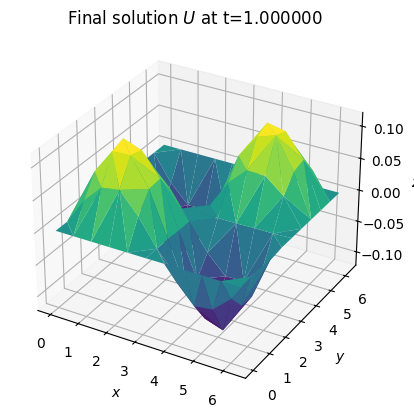

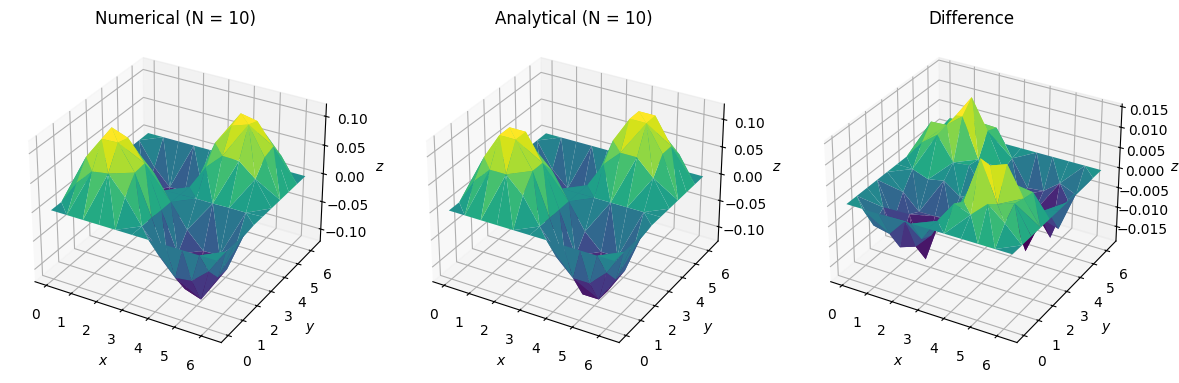

In [56]:
pt.plot2D(X, Y, U, triangles=triangles, title="Final solution $U$ at t=%f" %t)
U_ex = u_ex(X, Y, t)
pt.plot_comparison_2D(X,Y,U,U_ex,triangles,f"Numerical (N = {N})",f"Analytical (N = {N})")

**c**) Now we use the solver to perform a test on EOC. First, take the initial data $u_0=\sin(x)\sin(y)$ and the  ansatz $u_{ex}(x,y,t) = e^{\lambda t}u_0(x,y)$ for the exact solution. Substitute $u_{ex}$ into the heat equation and determine $\lambda$ so that $u_{ex}$ is the exact solution to the heat equation with $f=0$. Also compute the boundary data $g_D$ by using $u_{ex}$. 

Next, make sure that t-T is close to machine precision after the time loop. If not, there is a bug in the code. 

Now plot the exact solution $u$, the computed solution $U$ and their difference
at the final time $T=1$ for spatial mesh sizes $h = 2\pi/N$, $N=10, 20, 40$ and for $\theta \in \{ 0, 1, 0.5\}$. How should you choose the time step in each case?

Do you see a seond order convergence in maximum norm? Is this reasonable for all $\theta$ values you have tested?

Substituting $u_{ex}$ in the Heat Equation, with $f=0$, we obtain:
\begin{align}
    &\partial_{t}e^{\lambda t}\sin(x)\sin(y) = \Delta (e^{\lambda t}\sin(x)\sin(y))\\
    =  &\lambda e^{\lambda t}\sin(x)\sin(y) = e^{\lambda t}(-2\sin(x)\sin(y)) \\
      \implies &\lambda = -2
\end{align}

**d**) Now use your solver to compute a numerical solution with $u_0 = e^{-10((x-\pi)^2 + (y-\pi)^2)}$, and homogeneous Dirichlet boundary condition. Also set the forcing function $f$ to be zero. Plot the numerical solution at time $t=0, 1, 5, 10,20$ computed with $N=40$. Discuss your observations. 

## Problem 2 (The wave equation)

In this exercise, we implement a solver for the wave equation that is based on the finite difference method in both space and time. The equation takes the form,

\begin{alignat*}{3}
\partial_{tt} u  - \Delta u  &= f  \quad && \text{in } \Omega \times (0,T]
\\
u &= g_D \quad && \text{on } \partial \Omega \times (0, T]
\\
u(x,y,0) &=  u_0(x,y) \quad && \text{in } \Omega\\
u_t(x,0) &=  u_{t0}(x,y) \quad && \text{in } \Omega,
\end{alignat*}
where the spatial domain is the same as before, i.e. $\Omega=[0,2\pi]^2$.

Let $U_{wave}^k$ be the finite difference approxmation at time $t^k$. For the spatial discretization, we use the same finite difference matrix $A_h$ as in Lab 2. We will also use the central finite difference to approximate the   second derivative in time. The discretization can then be written as 
\begin{alignat*}{3}
\frac{U_{wave}^{k+1}-2U_{wave}^{k}+U_{wave}^{k-1}}{\Delta t^2} = ...\\
\end{alignat*}
Note: we are yet to impose the boundary condition. 


First, we recall the function that computes the finite difference matrix generated by the 5 point stencil from the 2d finite difference scheme for the Poisson problem you implemented in Lab 02.

In [62]:
from scipy.sparse import dok_matrix
import math
import pandas as pd

In [63]:
def fdm_poisson2d_matrix(h, N, gm):
    """Computes sparse matrix representation for a simple finite difference scheme in space.
      
    Parameters:
    ----------
    h: float
       spatial mesh size
       here choosen the same in each spatial direction
    N: integer
       number of space subdivision in each spatial direction.
    gm: function
       grid mapping which translates double grid indices (i, j) to index of the unknown
       
    Returns:
    -------
    A: 2D sparse matrix of type dok_matrix
        Matrix for diffusion equation
    """
    
    # Allocate a (sparse)
    N_unk = (N+1)**2
    A = dok_matrix((N_unk,N_unk))

    hh = h*h

    # Compute matrix A entries resulting by iterating
    # over rows and then colums of the (inner) grid indices.
    for i in range(1,N):
        for j in range(1,N):
            # Define row index related to unknown U_m(i,j)
            ri = gm(i,j)
            A[ri,ri] = 4  # U_ij
            A[ri,gm(i-1,j)] = -1  # U_{i-1,j}
            A[ri,gm(i+1,j)] = -1  # U_{i+1,j}
            A[ri,gm(i,j-1)] = -1  # U_{i,j-1}
            A[ri,gm(i,j+1)] = -1  # U_{i,j+1}
            
    #Rescale interior
    A = A/hh

    return A

**a**) In this numerical experiment, we choose the manufacture solution
\begin{alignat*}{3}
u = \sin(x)\sin(y)\sin(\sqrt{2}t).
\end{alignat*}
Use this to compute the forcing function $f$ and the initial and boundary data. Complete the following script. Run the code with $N=10,20,40$. Present and discuss EOC in maximum norm at the final time $T=1$. 

In [72]:
def u_wave_sol_a(x, y, t):
    return np.sin(x)*np.sin(y)*np.sin(np.sqrt(2)*t)

In [73]:
def u_wave_sol_b(x, y, t):
    return np.exp(-10*((x-np.pi)**2+(y-np.pi)**2))

In [74]:
def work_func(N, ex):
    # Mesh size
    h = (2*np.pi)/N
    alpha = 0.2
    m = 1 # trap - 1, FE,BE - 2
    T = 1
    t0 = 0

    #Map function to translate double index into a proper numbering
    def gm(i,j):
        #map the 2D indexing to 1D to represent vector v
        k = (N+1)*j+i
        return k

    #  Grid
    L = 2*np.pi
    X,Y = np.ogrid[0:L:(N+1)*1j, 0:L:(N+1)*1j]

    # What is the CFL condition for stability?
    dt = alpha*h**m
    M_t = math.ceil(T/dt) # nunber of time steps
    dt = T / M_t # remember this!

    # Total number of unknowns is N_unk = (N+1)*(N+1)
    N_unk = (N+1)**2

    # Sparse identity matrix ajnd convert it immediately to csc format (not csr this time!)
    Id = identity(N_unk).tocsc()

    A_h = fdm_poisson2d_matrix(h, N, gm)
    A_h = A_h.tocsc() 

    # Current time 
    t = t0

    # Initial condition 
    if ex == 'a':
        Uwave_grid_1 = u_wave_sol_a(X,Y,0) # t = 0
        Uwave_grid_0 = u_wave_sol_a(X,Y,0) - dt*np.sin(X)*np.sin(Y)*np.sqrt(2)
        # t_{k-1}. Hint: use the second initial condition to approximate the solution at t=-dt
    elif ex == 'b':
        Uwave_grid_1 = u_wave_sol_b(X,Y,0) # t = 0
        Uwave_grid_0 = u_wave_sol_b(X,Y,0) # -0 since our u_t0 = 0


    # We have to flatten out the resulting (N+1)*(N+1) array using ravel()
    Uwave_1 = Uwave_grid_1.ravel()
    Uwave_0 = Uwave_grid_0.ravel()
    # apply BC to the numerical solution at t=0 and t=-dt 
    for i in [0,N]:
        for j in range(0,N+1):
            ri = gm(i,j)       
            Uwave_0[ri] = 0       
            Uwave_1[ri] = 0      


    for j in [0,N]:
        for i in range(0,N+1):
            ri = gm(i,j)       
            Uwave_0[ri] = 0       
            Uwave_1[ri] = 0

    # Start time stepping 
    for i in range(M_t):
        # New time and time step
        t += dt

        # Update Uwave
        Uwave_2 = 2*Uwave_1 - Uwave_0 + dt**2 * (-A_h @ Uwave_1)

        # apply BC to Uwave_2
        for i in [0,N]:
            for j in range(0,N+1):
                ri = gm(i,j)       
                Uwave_2[ri] = 0       
        for j in [0,N]:
            for i in range(0,N+1):
                ri = gm(i,j)       
                Uwave_2[ri] = 0       

        # Update the solutions Uwave1 and Uwave0
        Uwave_0 = Uwave_1
        Uwave_1 = Uwave_2

    # End of time loop, calculate the maximum error
    return np.max(np.abs(Uwave_2 - u_wave_sol(X,Y,1).ravel()))

In [75]:
N_values = np.array([10,20,40])
max_norm = np.zeros(N_values.size)
for i in range(N_values.size):
    max_norm[i] = work_func(N_values[i],'a')

# Monomial order 3:
data = {'Max norm': max_norm,
        'Fraction': max_norm/max_norm[0]
       }

df = pd.DataFrame(data, index=N_values)
df = df[['Max norm', 'Fraction']]
df.index.name = "N"
display(df.style.set_caption("Table 3: Monomial order 3.").format('{:.3e}'))

,Max norm,Fraction
N,,
10,1.503e-02,1.000e+00
20,4.182e-03,2.782e-01
40,1.047e-03,6.967e-02


**b**) Use the same initial value $u_0$, boundary condition and forcing function as in Problem 1d), and $u_{t0}=0$. Compare with the solutions from 1d, what do you observe?


In [76]:
N_values = np.array([40])
max_norm = np.zeros(N_values.size)
for i in range(N_values.size):
    max_norm[i] = work_func(N_values[i],'b')

# Monomial order 3:
data = {'Max norm': max_norm,
        'Fraction': max_norm/max_norm[0]
       }

df = pd.DataFrame(data, index=N_values)
df = df[['Max norm', 'Fraction']]
df.index.name = "N"
display(df.style.set_caption("Table 4: (results b).").format('{:.3e}'))

,Max norm,Fraction
N,,
40,9.878e-01,1.000e+00
